In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input,Reshape
from sklearn.model_selection import train_test_split
from keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt

2024-12-14 07:45:59.426768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-14 07:45:59.426838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-14 07:45:59.429501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 07:45:59.454498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
amzn_raw = pd.read_csv('AMZN.csv')
amzn_raw

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
1,2015-01-02,15.425999641418457,15.425999641418457,15.737500190734863,15.347999572753906,15.628999710083008,55664000
2,2015-01-05,15.10949993133545,15.10949993133545,15.418999671936035,15.042499542236328,15.350500106811523,55484000
3,2015-01-06,14.76449966430664,14.76449966430664,15.149999618530273,14.619000434875488,15.112000465393066,70380000
4,2015-01-07,14.920999526977539,14.920999526977539,15.064000129699707,14.766500473022461,14.875,52806000
...,...,...,...,...,...,...,...
2493,2024-11-26,207.86000061035156,207.86000061035156,208.0,201.7899932861328,201.89999389648438,41673700
2494,2024-11-27,205.74000549316406,205.74000549316406,207.63999938964844,205.0500030517578,206.97999572753906,28061600
2495,2024-11-29,207.88999938964844,207.88999938964844,208.1999969482422,204.58999633789062,205.8300018310547,24892400
2496,2024-12-02,210.7100067138672,210.7100067138672,212.99000549316406,209.50999450683594,209.9600067138672,39523200


In [3]:
amzn = amzn_raw.iloc[1:].reset_index(drop=True)

In [4]:
amzn = amzn[['Adj Close', 'Close', 'High','Low','Open','Volume']]

amzn

,Adj Close,Close,High,Low,Open,Volume
0,15.425999641418457,15.425999641418457,15.737500190734863,15.347999572753906,15.628999710083008,55664000
1,15.10949993133545,15.10949993133545,15.418999671936035,15.042499542236328,15.350500106811523,55484000
2,14.76449966430664,14.76449966430664,15.149999618530273,14.619000434875488,15.112000465393066,70380000
3,14.920999526977539,14.920999526977539,15.064000129699707,14.766500473022461,14.875,52806000
4,15.02299976348877,15.02299976348877,15.156999588012695,14.805500030517578,15.015999794006348,61768000
...,...,...,...,...,...,...
2492,207.86000061035156,207.86000061035156,208.0,201.7899932861328,201.89999389648438,41673700
2493,205.74000549316406,205.74000549316406,207.63999938964844,205.0500030517578,206.97999572753906,28061600
2494,207.88999938964844,207.88999938964844,208.1999969482422,204.58999633789062,205.8300018310547,24892400
2495,210.7100067138672,210.7100067138672,212.99000549316406,209.50999450683594,209.9600067138672,39523200


In [5]:
amzn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2497 entries, 0 to 2496
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Adj Close  2497 non-null   object
 1   Close      2497 non-null   object
 2   High       2497 non-null   object
 3   Low        2497 non-null   object
 4   Open       2497 non-null   object
 5   Volume     2497 non-null   object
dtypes: object(6)
memory usage: 117.2+ KB


In [6]:
amzn.describe()

,Adj Close,Close,High,Low,Open,Volume
count,2497,2497,2497,2497,2497,2497
unique,2450,2450,2435,2442,2402,2465
top,125.9800033569336,125.9800033569336,124.4000015258789,49.099998474121094,162.5,60512000
freq,3,3,3,4,3,3


## <b>Indicators</b>

In [7]:
amzn = amzn.astype(float)

amzn['Change'] = amzn['Close'].diff()

prev_obv = 0
obv_val = []

for i, j in zip(amzn['Change'], amzn['Volume']):
    if i > 0:
        obv = prev_obv + j
    elif i < 0:
        obv = prev_obv-j
    else:
        obv = prev_obv

    prev_obv = obv
    obv_val.append(obv)

amzn['OBV'] = np.array(obv_val)

In [8]:
n = 14 # 2 weeks rsi

up_s, down_s = amzn['Change'].copy(), amzn['Change'].copy()

def up(x):
    return 0 if x < 0 else x

def down(x):
    return 0 if x > 0 else x

up_s = up_s.apply(up)
down_s=down_s.apply(down)

amzn['Up'] = up_s
amzn['Down'] = down_s

# Exponential Weighted Moving Average - EWMA
ewma_up = amzn['Up'].ewm(span = n).mean()
ewma_down = amzn['Down'].ewm(span = n).mean()

RS = ewma_up / ewma_down
RSI = 100.0 - (100.0 / (1.0 + RS))

amzn['RSI'] = RSI

In [9]:
n = 14 

l14, h14 = amzn['Low'].copy(), amzn['High'].copy()

l14 = l14.rolling(window = n).min()
h14 = h14.rolling(window = n).max()

#stochastic oscillator
k_pcent = 100 * ((amzn['Close'] - l14) / (h14-l14))

amzn['Low14'] = l14
amzn['High14'] = h14
amzn['K_percent'] = k_pcent

In [10]:
amzn = amzn.copy().iloc[14:].reset_index(drop=True)
amzn = amzn[['Close', 'High', 'Low', 'Open', 'Volume', 'Change', 'OBV', 'RSI', 'Low14', 'High14', 'K_percent']]
amzn

,Close,High,Low,Open,Volume,Change,OBV,RSI,Low14,High14,K_percent
0,15.619500,15.846500,15.386000,15.404000,89928000.0,0.103500,1.585480e+08,166.780606,14.2625,15.846500,85.669182
1,15.483000,15.650000,15.376000,15.591000,63394000.0,-0.136500,9.515400e+07,214.124126,14.2625,15.846500,77.051739
2,15.337500,15.512000,15.131500,15.315000,58406000.0,-0.145500,3.674800e+07,328.983629,14.2625,15.846500,67.866124
3,15.195500,15.575500,15.190000,15.490500,61276000.0,-0.141999,-2.452800e+07,830.868269,14.2625,15.846500,58.901529
4,15.589000,15.640000,14.966500,15.236500,173132000.0,0.393499,1.486040e+08,224.341104,14.2625,15.846500,83.743652
...,...,...,...,...,...,...,...,...,...,...,...
2478,207.860001,208.000000,201.789993,201.899994,41673700.0,6.410004,1.156790e+10,277.915669,195.7500,215.899994,60.099277
2479,205.740005,207.639999,205.050003,206.979996,28061600.0,-2.119995,1.153984e+10,462.493934,195.7500,215.899994,49.578206
2480,207.889999,208.199997,204.589996,205.830002,24892400.0,2.149994,1.156473e+10,303.972207,195.7500,215.899994,60.248154
2481,210.710007,212.990005,209.509995,209.960007,39523200.0,2.820007,1.160425e+10,222.739231,195.7500,215.899994,74.243232


In [11]:
# Normalizing using minmax

scaler = MinMaxScaler(feature_range=(0,1))
amzn_scaled = scaler.fit_transform(amzn)

amzn_scaled

array([[2.13167512e-03, 1.66926324e-03, 2.14124799e-03, ...,
        0.00000000e+00, 0.00000000e+00, 8.56691823e-01],
       [1.44541435e-03, 6.88661691e-04, 2.09020875e-03, ...,
        0.00000000e+00, 0.00000000e+00, 7.70517386e-01],
       [7.13906627e-04, 0.00000000e+00, 8.42208209e-04, ...,
        0.00000000e+00, 0.00000000e+00, 6.78661244e-01],
       ...,
       [9.68778954e-01, 9.61574559e-01, 9.67893951e-01, ...,
        1.00000000e+00, 1.00000000e+00, 6.02481542e-01],
       [9.82956649e-01, 9.85478230e-01, 9.93007065e-01, ...,
        1.00000000e+00, 1.00000000e+00, 7.42432320e-01],
       [9.96681806e-01, 9.90618252e-01, 9.93721663e-01, ...,
        1.00000000e+00, 1.00000000e+00, 8.77916020e-01]])

## <b>LSTM</b>

In [12]:
sequence_len = 30   # predict data based on the previous month
X, y = [], []

for i in range(len(amzn_scaled) - sequence_len):
    X.append(amzn_scaled[i : i+sequence_len])
    y.append(amzn_scaled[i+sequence_len])

X, y = np.array(X), np.array(y)

X.shape #(samples, sequence length, features)
y.shape

(2453, 11)

In [13]:
# 64 / 16 / 20
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


In [14]:
# Define the LSTM model
lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=False),
    Dense(8, activation='relu'),
    Dense(y_train.shape[1])  # Number of target variables (columns)
])

lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(name='rmse')])

lstm_history = lstm.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=128, 
                    validation_data=(X_val, y_val),
                    verbose=1)

2024-12-14 07:46:07.812303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10396 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:60:00.0, compute capability: 6.1


Epoch 1/20


2024-12-14 07:46:17.435362: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.2124 - rmse: 0.4605 - val_loss: 0.2900 - val_rmse: 0.5385
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.1572 - rmse: 0.3965 - val_loss: 0.2533 - val_rmse: 0.5033
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1358 - rmse: 0.3684 - val_loss: 0.2178 - val_rmse: 0.4666
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1136 - rmse: 0.3371 - val_loss: 0.1835 - val_rmse: 0.4284
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0919 - rmse: 0.3031 - val_loss: 0.1479 - val_rmse: 0.3845
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0726 - rmse: 0.2694 - val_loss: 0.1170 - val_rmse: 0.3421
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0570 - rmse: 0.2387 - val_loss: 0.0912 - val_rmse: 0.3021
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0467 - rmse: 0.2159 - val_loss: 0.0714 - val_rmse: 0.2672
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss:

In [15]:
test_loss, test_rmse = lstm.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test RMSE: {test_rmse}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0094 - rmse: 0.0970
Test Loss: 0.010410797782242298
Test RMSE: 0.10203331708908081


In [16]:
y_pred = lstm.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [17]:
# decoding values back to original
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

#close price only

close_pred = y_pred_original[:,1]
close_test = y_test_original[:,1]

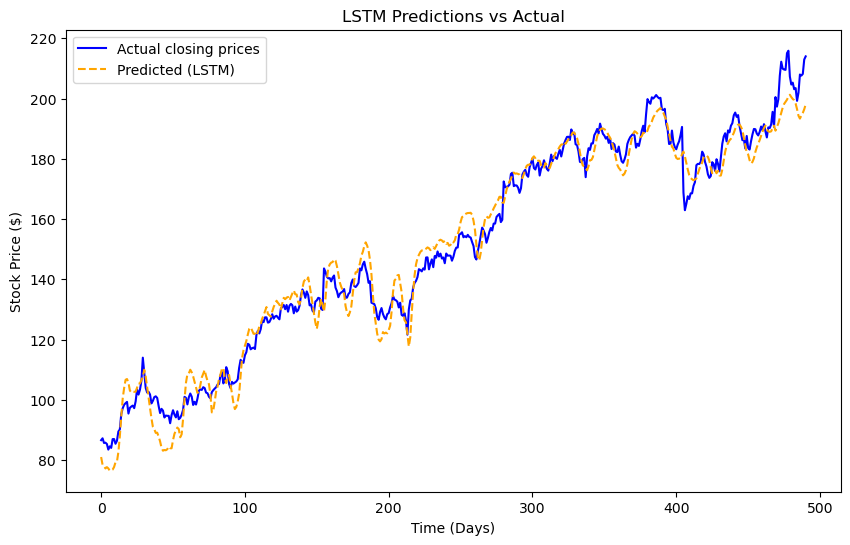

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(close_test, label='Actual closing prices', color='blue')
plt.plot(close_pred, label='Predicted (LSTM)', color='orange', linestyle='dashed')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.show()

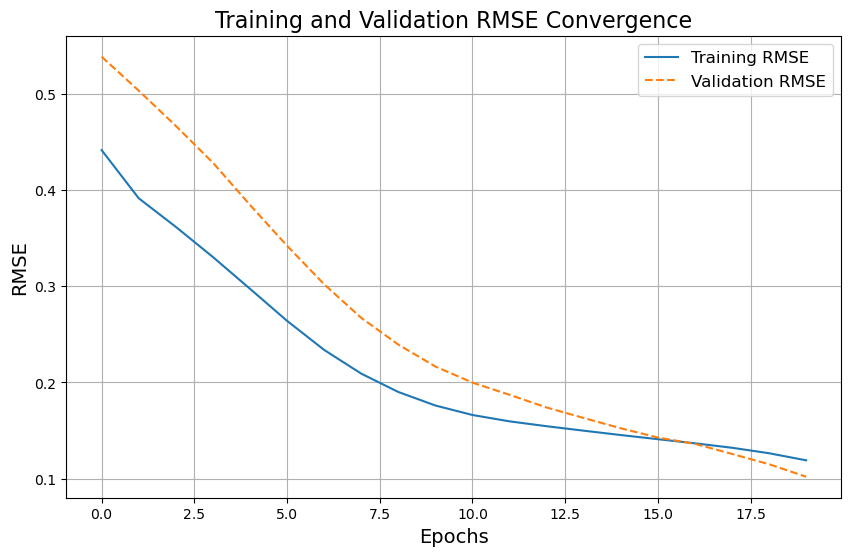

In [19]:
train_rmse = lstm_history.history['rmse']
val_rmse = lstm_history.history['val_rmse']

# Plot the training and validation RMSE
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE', linestyle='--')
plt.title('Training and Validation RMSE Convergence', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

## <b>CNN-LSTM</b>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten

In [21]:
clstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    LSTM(32, return_sequences=False),
    Dense(8, activation='relu'),
    Dense(y_train.shape[1])
])

clstm.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(name='rmse')])

clstm_history = clstm.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=128, 
                    validation_data=(X_val, y_val),
                    verbose=1)

clstm.summary()

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.1872 - rmse: 0.4321 - val_loss: 0.2478 - val_rmse: 0.4978
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1234 - rmse: 0.3513 - val_loss: 0.1937 - val_rmse: 0.4401
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1006 - rmse: 0.3171 - val_loss: 0.1571 - val_rmse: 0.3964
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0799 - rmse: 0.2827 - val_loss: 0.1266 - val_rmse: 0.3558
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0653 - rmse: 0.2556 - val_loss: 0.1013 - val_rmse: 0.3183
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0515 - rmse: 0.2268 - val_loss: 0.0808 - val_rmse: 0.2843
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0424 - rmse: 0.2059 - val_loss: 0.0646 - val_rmse: 0.2541
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0340 - rmse: 0.1843 - val_loss: 0.0521 - val_rmse: 0.2282
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/st

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 32)         │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,315 (114.52 KB)

 Trainable params: 9,771 (38.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,544 (76.35 KB)

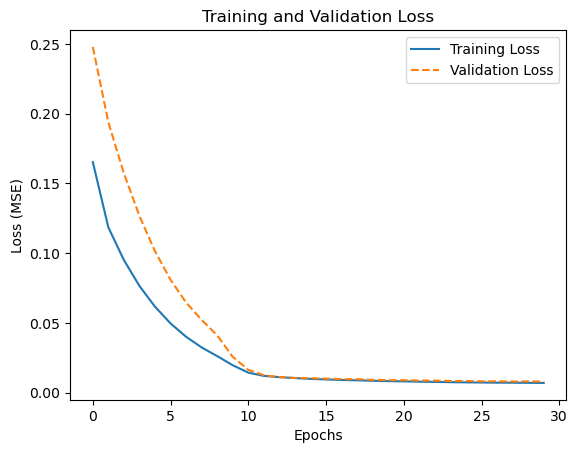

In [22]:
# Plot training and validation loss
plt.plot(clstm_history.history['loss'], label='Training Loss')
plt.plot(clstm_history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [23]:
clstm_test_loss, clstm_test_rmse = clstm.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test RMSE: {test_rmse}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - rmse: 0.0871
Test Loss: 0.010410797782242298
Test RMSE: 0.10203331708908081


In [24]:
y_pred = clstm.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [25]:
# decoding values back to original
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

#close price only

clstm_close_pred = y_pred_original[:,1]
close_test = y_test_original[:,1]

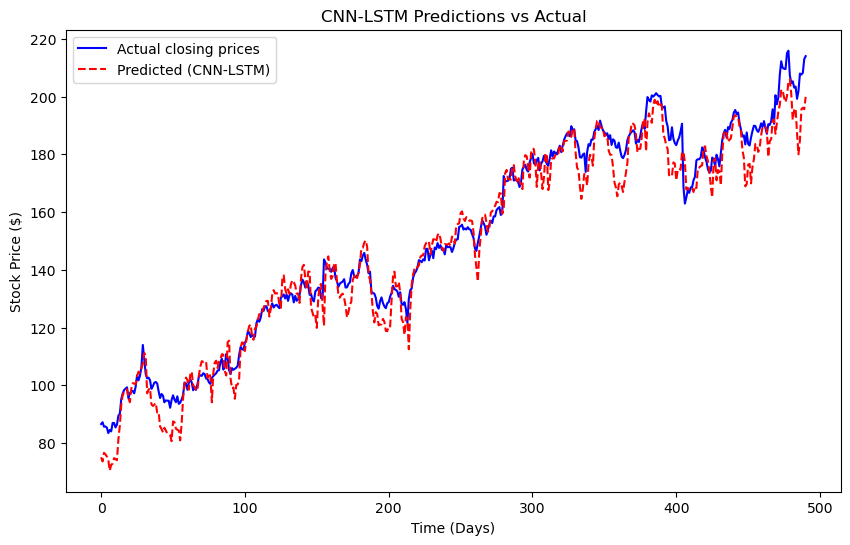

In [26]:
errors = clstm_close_pred - close_test
e_std = np.std(errors)

plt.figure(figsize=(10, 6))
plt.plot(close_test, label='Actual closing prices', color='blue')
plt.plot(clstm_close_pred, label='Predicted (CNN-LSTM)', color='red', linestyle='dashed')

#plt.fill_between(range(len(clstm_close_pred)), clstm_close_pred-e_std, clstm_close_pred+e_std, color='')

plt.title('CNN-LSTM Predictions vs Actual')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.show()

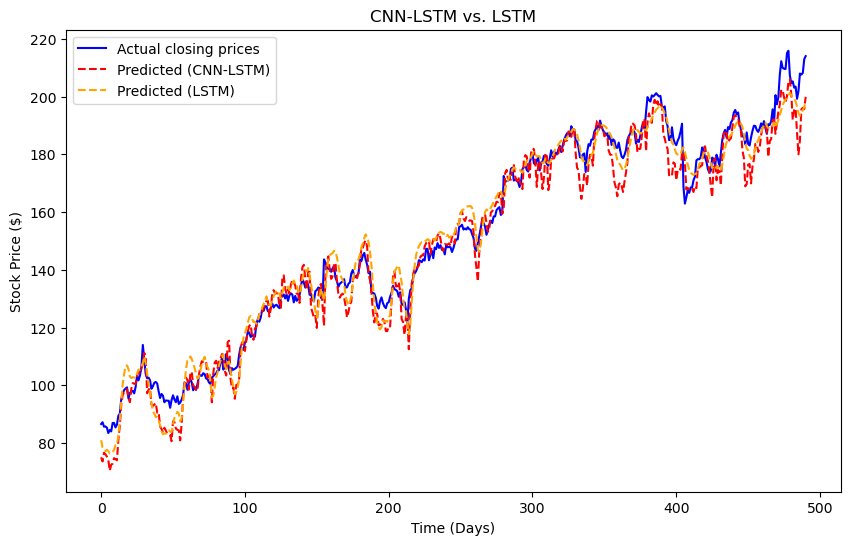

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(close_test, label='Actual closing prices', color='blue')
plt.plot(clstm_close_pred, label='Predicted (CNN-LSTM)', color='red', linestyle='dashed')
plt.plot(close_pred, label='Predicted (LSTM)', color='orange', linestyle='dashed')
plt.title('CNN-LSTM vs. LSTM')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.show()